In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

DEFAULT_PRECISION = 0.000001
TRANSFORMATIONS = [('divide_xis', {'min_num_parts': 1, 'max_num_parts': 6})]

In [2]:
def xo(col, row):
    return _xo[str(col)][row]

def xor(col, row):
    return _xor[str(col)][row]

def xr(col, row):
    return _xo[str(col)][_xor[str(col)][row]]


In [3]:
def get_I(k, i):
    assert k >= 0
    assert 1 >= i >= 0
    if k == 1:
        return i
    else:
        k = np.float128(k)
        i = np.float128(i)
        return (pow(k, i) - 1) / (k-1)

def get_i(k, I):
    assert k >= 0
    assert 1 >= I >= 0
    if k == 1:
        return I
    else:
        k = np.float128(k)
        I = np.float128(I)
        return np.log(I * (k - 1) + 1) / np.log(k)

def get_mean_i(df, k, row1, row2, col):
    assert k >= 0
    k = np.float128(k)
    sum_mean_i = np.float128(0)
    xi_1 = np.float128(df[str(col)][row1])
    xi_2 = np.float128(df[str(col)][row2])
    for row_index in range(row1, row2 + 1):
        xi = (np.float128(df[str(col)][row_index]) - xi_1) / (xi_2 - xi_1)
        mean_i = np.float128((pow(k, xi) - 1) / (k-1))
        sum_mean_i += mean_i
    return sum_mean_i / (row2 + 1 - row1)

def getk50(df, col=None, row1=None, row2=None, precision=DEFAULT_PRECISION):
    col = col or df.columns[0]
    row1 = row1 or 0
    row2 = row2 or len(df) -1
    precision = precision or DEFAULT_PRECISION
    k1 = np.float128(0.999)
    k2 = np.float128(1.001)
    precision = np.float128(precision)
    mean_i_1 = get_mean_i(df, k1, row1, row2, col)
    mean_i_2 = get_mean_i(df, k2, row1, row2, col)
    if mean_i_1 < mean_i_2:
        if mean_i_1 > np.float128(0.5):
            k1 = np.float128(0.00000001)
            k2 = np.float128(0.99999999)
        elif mean_i_2 < np.float128(0.5):
            k1 = np.float128(1.00000001)
            k2 = np.float128(99999999)
        else:
            raise Exception(mean_i_1, mean_i_2)
    else:
        if mean_i_2 > np.float128(0.5):
            k1 = np.float128(1.00000001)
            k2 = np.float128(99999999)
        elif mean_i_1 < np.float128(0.5):
            k1 = np.float128(0.00000001)
            k2 = np.float128(0.99999999)
        else:
            raise Exception(mean_i_1, mean_i_2)
    mean_i_1 = get_mean_i(df, k1, row1, row2, col)
    mean_i_2 = get_mean_i(df, k2, row1, row2, col)
    while abs(k2 - k1) > precision:
        if abs(mean_i_1 - np.float128(0.5)) < precision:
            return (k1, mean_i_1, 1)
        if abs(mean_i_2 - np.float128(0.5)) < precision:
            return (k2, mean_i_2, 2)
        k3 = (k1 + k2) / 2
        mean_i_3 = get_mean_i(df, k3, row1, row2, col)
        if abs(mean_i_3 - np.float128(0.5)) < precision:
            return (k3, mean_i_3, 3)
        if mean_i_2 > mean_i_1:
            if mean_i_3 > np.float128(0.5):
                k2 = k3
                mean_i_2 = mean_i_3 
            else:
                k1 = k3
                mean_i_1 = mean_i_3 
        else:  
            if mean_i_3 > np.float128(0.5):
                k1 = k3
                mean_i_1 = mean_i_3 
            else:
                k2 = k3
                mean_i_2 = mean_i_3 
    return (k3, mean_i_3, 4)


In [4]:
def get_xor(dfxo):
    _xor = pd.DataFrame()
    for col in dfxo:
        _xor[col] = dfxo[col].sort_values(inplace=False).index
    return _xor

In [5]:
def get_xr(dfxo):
    _xr = pd.DataFrame(index=dfxo.index, columns=dfxo.columns)
    _xr = _xr.apply(lambda x: [xr(int(col), x.name) for col in dfxo.columns], 1)
    return _xr

In [6]:
def xi(col, value):
    _min = np.float128(_xr[col].min())
    _max = np.float128(_xr[col].max())
    return (np.float128(value) - _min) / (_max - _min)

In [7]:
def get_xi(dfxo):
    _xi = pd.DataFrame(index=dfxo.index, columns=dfxo.columns)
    _xr = get_xr(dfxo)
    _xi = _xr.apply(lambda x: [xi(col, x[col]) for col in _xr.columns], 1)
    return _xi

In [8]:
def get_k_by_parts(dfxo, dfxi, num_parts= 4, precision=DEFAULT_PRECISION):
    precision = precision or DEFAULT_PRECISION
    # dfxt = dfxi.copy()
    dfxt = pd.DataFrame(index=np.arange(0,51), columns=['xt_' + col for col in dfxi.columns])
    dfxot = dfxo.copy()
    for col in dfxo.columns:
        dfxot['xt_' + col] = np.nan
    parts = np.array_split(np.array(dfxot.index), num_parts)
    for part in parts:
        row1 = part[0]
        row2 = part[-1]
        for col in dfxi.columns:
            value_min = dfxi[col][row1]
            value_max = dfxi[col][row2]
            k, mean_i, case = getk50(dfxi, col, row1, row2, precision)
            for row in range(row1, row2 + 1):
                value = dfxi[col][row]
                transformed_value = transform_value(value, value_min, value_max, k)
                dfxt['xt_' + col].set_value(row, transformed_value)
                dfxot['xt_' + col].set_value(xor(int(col), row), transformed_value)
    return dfxt, dfxot

def transform_value(value, value_min, value_max, k):
    exponent = (value - value_min) / (value_max - value_min)
    return (value_min + ((value_max - value_min) * (pow(k, exponent) - 1) / (k - 1)))

In [9]:
def divide_xis(dfxo, min_num_parts, max_num_parts):
    xts = {}
    xots = {}
    dfxi = get_xi(dfxo)
    for num_parts in range(min_num_parts, max_num_parts + 1):
        _xt, _xot = get_k_by_parts(dfxo, dfxi, num_parts)
        xts[num_parts] = _xt
        xots[num_parts] = _xot
    return xts, xots

In [10]:
def get_xots(dfxo):
    xts = {}
    xots = {}
    for transformation, params in TRANSFORMATIONS:
        xts, xots = globals()[transformation](dfxo, **params)
    return xts, xots

In [11]:
def plot_transformations(_xo, xots):
    plt.close('all')
    num_rows = np.ceil((len(xots) + 1) / 2)
    iii = 1
    for key, _xot in xots.items():
        if iii == 1:
            sp = plt.subplot(num_rows, 2, 1)
            sp.plot([_xot['0'].min(), _xot['0'].max()], [_xot['0'].min(), _xot['0'].max()], 'bs-')
            sp.plot(_xot['0'], _xot['1'], 'ro')
            sp.set_title('Original data (x1,x2)')
            #sp.set_xlabel('Original 1')
            #sp.set_ylabel('Original 2')
        iii += 1
        sp = plt.subplot(num_rows, 2, iii)
        sp.plot([0, 1], [0, 1], 'bs-')
        sp.plot(_xot['xt_0'], _xot['xt_1'], 'ro')
        sp.set_title('with xo divided in ' + str(key))
    sp.figure.set_size_inches(20, num_rows * 10)
    return sp.figure

In [12]:
def get_best_transformation(xots):
    highest_correlation = 0
    best_transformation = None
    for key, _xot in xots.items():
        if best_transformation is None:
            xt_diff = abs(_xot['0'] - _xot['1']).sum()
            xt_sum = abs(_xot['0'] + _xot['1'] - 1).sum()
            correlation = 1 - xt_diff / xt_sum
            print("original data: ", correlation, ((xt_sum - xt_diff) / (xt_sum + xt_diff) ))
        xt_diff = abs(_xot['xt_0'] - _xot['xt_1']).sum()
        xt_sum = abs(_xot['xt_0'] + _xot['xt_1'] - 1).sum()
        correlation = 1 - xt_diff / xt_sum
        print("xo / {}: ".format(str(key)), correlation, ((xt_sum - xt_diff) / (xt_sum + xt_diff) ))
        if correlation > highest_correlation:
            highest_correlation = correlation
            best_transformation = key
    return best_transformation, xots[best_transformation]

In [13]:
def plot_transformation(_xot):
    fig2, ((sp21, sp22), (sp23, sp24)) = plt.subplots(2, 2)
    fig2.set_size_inches(20, 20)
    _xot = xots[3] # replace by call to choose_best_transformation
    sp21.plot(_xot['0'], _xot['1'], 'ro')
    sp21.plot([_xot['0'].min(), _xot['0'].max()], [_xot['0'].min(), _xot['0'].max()], 'bs-')
    sp22.plot(_xot['xt_1'], _xot['1'], 'ro')
    sp23.plot(_xot['0'], _xot['xt_0'], 'ro')
    sp24.plot([0, 1], [0, 1], 'bs-')
    sp24.plot(_xot['xt_1'], _xot['xt_0'], 'ro')
    return fig2

In [14]:
_xo = pd.read_csv('../../data/base_data.tsv', sep="\t")
_xo

,0,1
0,5,4
1,22,25
2,32,37
3,35,27
4,37,39
5,43,51
6,42,31
7,44,61
8,47,59
9,49,50


In [15]:
_xor = get_xor(_xo)
_xor

,0,1
0,0,0
1,1,1
2,2,3
3,3,6
4,4,2
5,6,4
6,5,9
7,7,5
8,8,14
9,9,13


In [16]:
_xr = get_xr(_xo)
_xr

,0,1
0,5,4
1,22,25
2,32,27
3,35,31
4,37,37
5,42,39
6,43,50
7,44,51
8,47,57
9,49,58


In [17]:
xts, xots = get_xots(_xo)

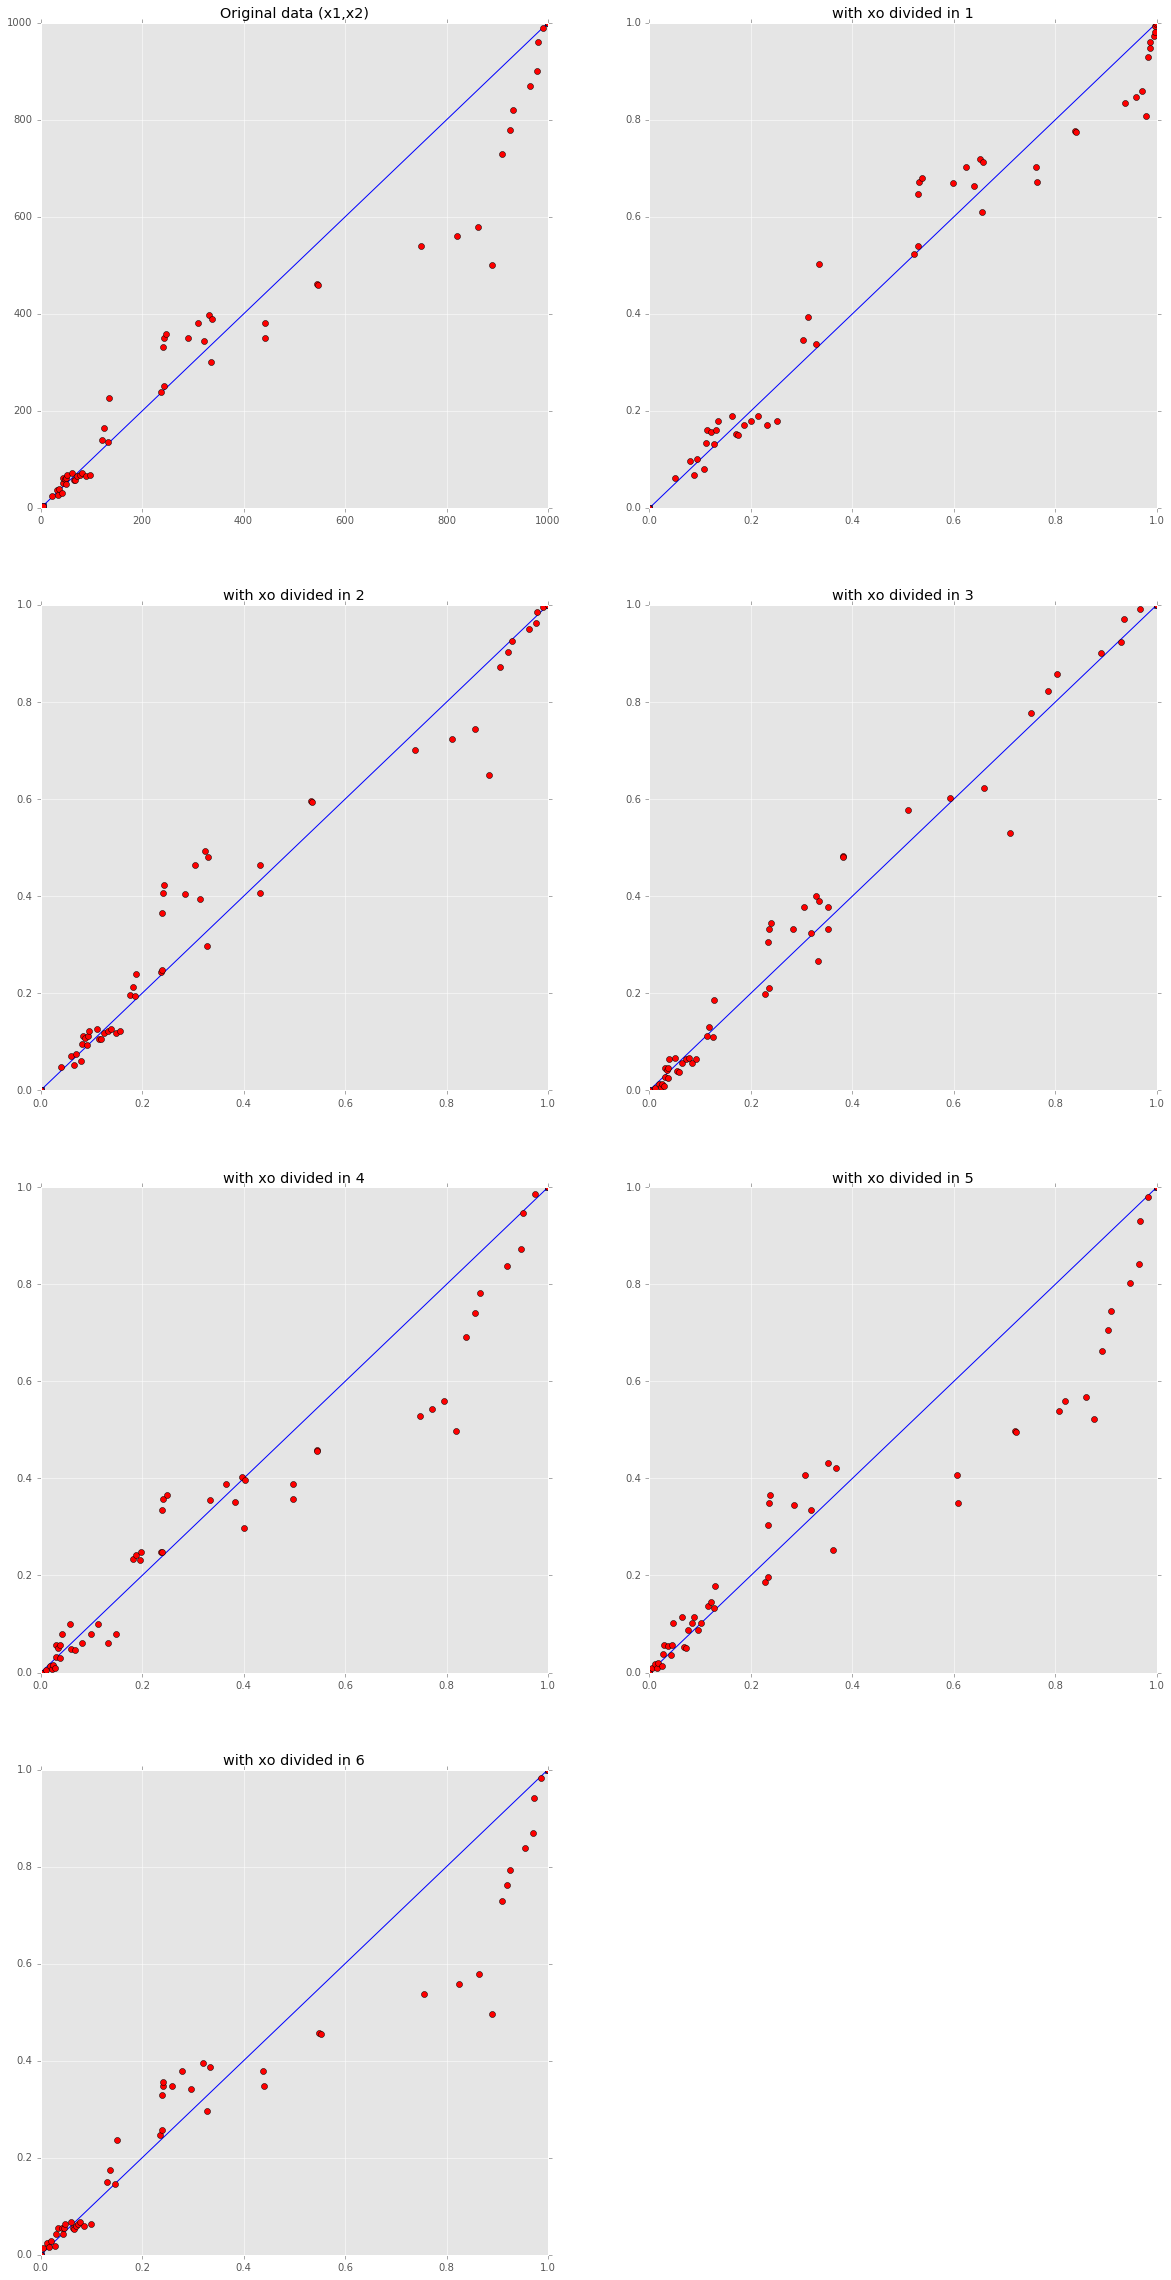

In [18]:
fig1 = plot_transformations(_xo, xots)

In [19]:
best_transformation, _xot = get_best_transformation(xots)
_xot

original data:  0.909227550027998 0.8335629947853341
xo / 1:  0.9191143088375204 0.8503344214400914
xo / 2:  0.9266956309268418 0.863404321858003
xo / 3:  0.9485275917045314 0.9020946096361957
xo / 4:  0.9022712073818409 0.8219436471460876
xo / 5:  0.8737675441392118 0.7758323244834784
xo / 6:  0.9007675830593751 0.8194514364545257


,0,1,xt_0,xt_1
0,5,4,0.000000,0.000000
1,22,25,0.011622,0.005607
2,32,37,0.019738,0.012387
3,35,27,0.022383,0.006489
4,37,39,0.024203,0.013937
5,43,51,0.029952,0.027039
6,42,31,0.028963,0.008521
7,44,61,0.030954,0.045288
8,47,59,0.034038,0.040921
9,49,50,0.036160,0.025643


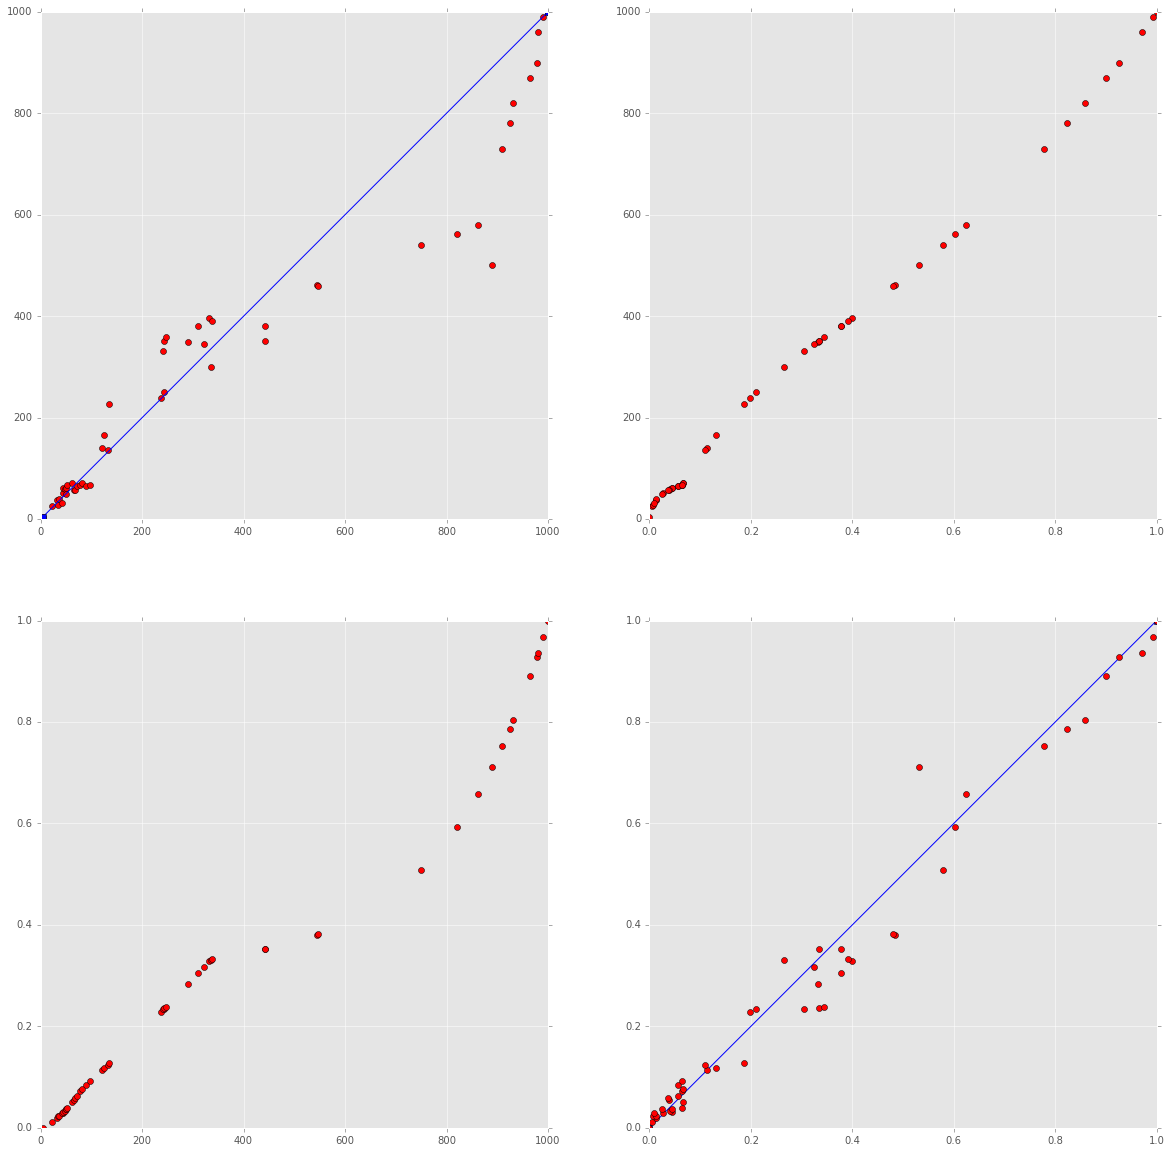

In [20]:
fig2 = plot_transformation(_xot)